# XENON Analysis exercise: electron lifetime

Jelle, December 2019 -- updated May 2020

This notebook shows how to do an electron lifetime determination on an 83mKr run using strax and python histogramming / fitting tools. We cover everything from run selection, data cleaning (cuts), model construction, fitting, and basic goodness of fit probing 

A few parts are left out to provide an exercise for the reader. However, the real exercises are the end, as suggestions for extension.

This assumes you are already familiar with the strax tutorials. If not, you will have to refer to them frequently to solve the exercises.

## Setup

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import straxen
from multihist import Histdd, Hist1d

# Print out exactly what versions we are using, for reference / troubleshooting:
import sys
import os.path as osp
print(f"Python {sys.version} at {sys.executable}\n"
      f"Straxen {straxen.__version__} at {osp.dirname(straxen.__file__)}")

Python 3.6.10 |Anaconda, Inc.| (default, Mar 25 2020, 23:51:54) 
[GCC 7.3.0] at /opt/XENONnT/anaconda/envs/XENONnT_development/bin/python
Straxen 0.9.0 at /opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.6/site-packages/straxen


## 1. Run selection

#### [1A] Load the strax context in `st` 

In [4]:
st = straxen.contexts.xenon1t_dali()

#### [1B] Use `st.select_runs` to select Kr runs that have event_info available, assign this to 'runs'.

In [6]:
runs = st.select_runs(run_mode='kr*', available='event_info')

Checking data availability: 100%|██████████| 5/5 [01:40<00:00, 20.07s/it]


Let's just pick the first available run for now:

In [10]:
print(len(runs))
run_info = runs.iloc[0]
print(run_info['name'])

30
170206_1355


## 2. Data loading

#### [2A] Load event_info for the run you just selected. Store it in `events`

In [11]:
events = st.get_df(run_info['name'], 'event_info')

Let's plot the events in (drift time, S2). We already made a plotting function for you to save time; you just have to fill out the x, y, and color axis labels:

168,578 events remaining


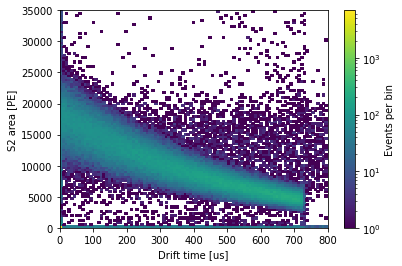

In [12]:
def dtplot(events, scatter=None, print_n=True):
    if scatter is None:
        scatter = len(events) < 2000
            
    x, y = events['drift_time']/1e3, events['s2_area']
    xbins, ybins = (np.linspace(0, 800, 100), 
                    np.linspace(0, 3.5e4, 100))

    if scatter:
        plt.scatter(x, y, marker='.', edgecolors='none', c='k', s=7)
        plt.xlim(xbins[0], xbins[-1])
        plt.ylim(ybins[0], ybins[-1])
    else:
        mh = Histdd(x, y, bins=(xbins, ybins))
        mh.plot(log_scale=True, cblabel="Events per bin")
        
    plt.xlabel("Drift time [us]")
    plt.ylabel("S2 area [PE]")
    if print_n:
        print(f"{len(events):,} events remaining")

dtplot(events)

## 3. Cuts

We should select a clean sample of Kr events, so that we can model the data without too many outliers. After commissioning, straxen will have standardized cuts you can use or fine-tune.
The simplest start would be to cut on the plot you made above, i.e. on S2 and drift time, the dimensions we're going to fit our model to. This is not always a great idea: such cuts can easily bias your data (and therefore your answer), unless you are careful to only remove remote outliers. 



**Tips for cuts**:
  * What to cut on?
    * Ideally, cut on dimensions that are orthogonal/unrelated to the space you're using for modelling. Almost nothing is completely unrelated though -- this takes some expertise.
    * Slightly worse is cutting directly on the space you're fitting in. You will bias your data, but in a way that could be easy to model (since it's in the same space).
    * Avoid cutting on something that is very related to, but not exactly, one of the dimensions that you are fitting in. This biases the data in a way that is hard to model.
  * How strong to cut?
    * Don't be afraid to cut strongly if you've found a good orthogonal dimension to do it in. If you have to cut in the space, or worst of all, in something correlated to the space, use a high acceptance (= pass many good events).

Let's start with something simple: a cut on the space itself, just to remove extreme outliers at very low S2 and drift time.

168,578 events remaining


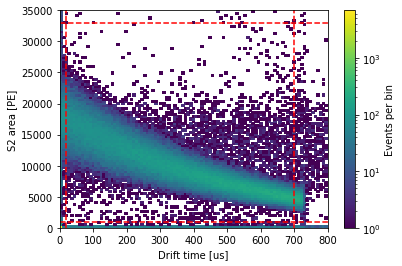

In [13]:
s2_bounds = (1e3, 33e3)
dt_bounds = (20e3, 700e3)

for x in s2_bounds:
    plt.axhline(x, color='r', linestyle='--')
for x in dt_bounds:
    plt.axvline(x/1e3, color='r', linestyle='--')
    
dtplot(events)

#### [3A.] Implement the `range_selection` function below

In [14]:
def range_selection(data, column, bounds):
    """Return rows of data for which the value column is in between bounds.
    
    :param data: pandas dataframe
    :param column: string, name of one of its columns
    :param bounds: 2-tuple, (left, right) bound
    """
    return data[(bounds[0] < data[column]) & (data[column] < bounds[1])]

# Hint: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#boolean-indexing

Now let's do the cut:

125,114 events remaining


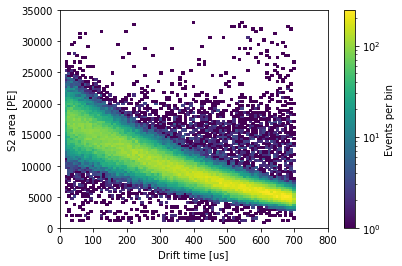

In [15]:
events = range_selection(events, 's2_area', s2_bounds)
events = range_selection(events, 'drift_time', dt_bounds)
dtplot(events)

There are still a lot of outliers. We could do quite a few more cuts, for example (a) a cut on cS1 and (b) a cut on the ratio between the to Kr S1s. Cut (a) is much more dangerous than (b).

#### [3B.] Explain why a strong cut on cS1 would be dangerous for fitting electron lifetime.

#### [3C.] Add a new column `s1_ratio` to `events`, containing the ratio between the primary and secondary S1 area.

In [16]:
events['s1_ratio'] = events['alt_s1_area'] / events['s1_area']

Let's do both cuts at once -- but only do a weak cut on cS1.

Text(0, 0.5, 'Ratio between S1s')

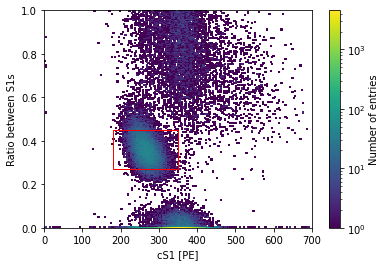

In [21]:
def draw_box(x, y, **kwargs):
    """Draw rectangle, given x-y boundary tuples"""
    plt.gca().add_patch(matplotlib.patches.Rectangle(
        (x[0], y[0]), x[1] - x[0], y[1] - y[0], facecolor='none', **kwargs))

Histdd(events['cs1'], 
       events['s1_ratio'], 
       bins=(np.linspace(0, 700, 200), 
             np.linspace(0, 1, 200)
            )).plot(log_scale=True)

cs1_bounds = [180, 350]
s1_ratio_bounds = [0.27, 0.45]
draw_box(cs1_bounds, s1_ratio_bounds, edgecolor='r')

plt.xlabel("cS1 [PE]")
plt.ylabel("Ratio between S1s")

18,963 events remaining


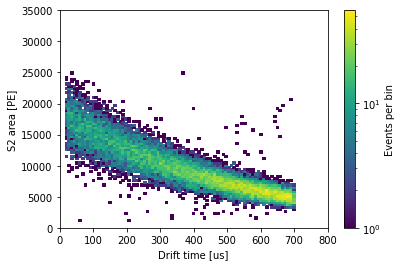

In [22]:
df = events
df = range_selection(df, 's1_ratio', s1_ratio_bounds)
df = range_selection(df, 'cs1', cs1_bounds)
dtplot(df)

Unfotunately, the clustering in strax is currently poorly calibrated for Kr (it was somewhat but not much better in pax), so not many Kr S1s are properly separated. Thus only a few Kr events remain after the cut. We are working on better clustering, and also on algorithms that make it easier to reprocess data with different clustering settings (without having to go all the way back to low-level data, as you would now).

## 4. Model construction

I will here assume the following model. It is simple compared to a full detector response model, e.g. in bbf or flamedisx, but still might be daunting on first reading. And it might be wrong / not capture the relevant effects, I guess we'll see...
  * 83mKr S2s initially produce a Gaussian number of electrons: N_produced ~ Gauss(N_0, sigma_0).
  * The number of electrons surviving drift is binomial: N_survived ~ Binom(n=N_produced, p=1 - exp(-dt/elife))
  * We could go all out and calculate P(N_survived) = $\int$ dN_produced P(N_produced) P(N_survived | N_produced)...
  * ... but I am  too lazy to do math here. Let's assume the distribution is Gaussian and try to guess the means and widths:
    * The mean number of surviving electrons is clearly N_0 * p. 
    * As we increase drift time, the spread evolves due to two effects:
       * The initial spread is scaled down by $p$, just like the mean. The absorption just scales everything down.
       * Electron survival is binomial, which has an std of sqrt(mean * (1-p)).
       * Adding these two spreads in quadreature (sqrt(variance)s) in quadrature, we expect a spread of sqrt((s0 * p)**2 +  N0 * p * (1-p))
  * I'm also going to assume S2 = number of electrons * g2, i.e. ignore single electron resolution. 

#### [4A] Fill in the missing lines implementing the model below

In [23]:
def s2_mean_std(dt, params):
    """Return two arrays (mean_s2, sigma_s2), each of same length as dt,
    containing the mean and standard deviation of Kr S2s at the given drift time.
    :param dt: Numpy array of drift times (in us)
    :param params: Dictionary of parameters (elife in us, n0 and sigma_0)
    """
    p = np.exp(-dt/params['elife'])
    mean_nel = params['n0'] * p
    mean_s2 = mean_nel * g2
    sigma_s2 = g2 * np.sqrt(
        (params['sigma_0'] * p)**2    # Initial n_el resolution, scaled by p due to elife.
        + mean_nel * (1 - p))         # Extra variance from binomial process
    return mean_s2, sigma_s2


Let's test it out:

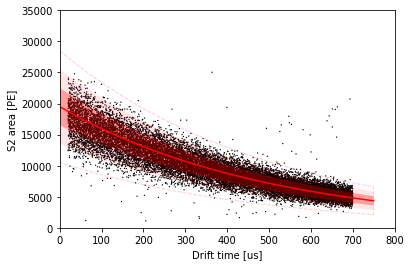

In [24]:
s2 = df['s2_area'].values
dt = df['drift_time'].values / 1e3
g2 = 30
guess = dict(elife=500, n0=650, sigma_0=100)

def comparison(df, params, **kwargs):
    """Compare the data in df with our elife model, assuming params"""
    dtplot(df, print_n=False, **kwargs)
    _dt = np.linspace(0, 750, 100)
    m, s = s2_mean_std(_dt, params)
    plt.plot(_dt, m, color='r')
    for sigma in [1, 2, 3]:
        plt.fill_between(
            _dt, 
             m - sigma * s, 
             m + sigma * s, 
             facecolor='r' if sigma < 3 else 'none',
             edgecolor='none' if sigma < 3 else 'r',
             linestyle='--',
             alpha={1: 0.3, 2: 0.1, 3: 0.2}[sigma])
        
comparison(df, guess, scatter=True)

Doesn't look too bad... but let's see how it does after fitting.

## 5. Fitting

First, decide if you want to fit the events themselves (unbinned likelihood), a histogram of them (binned likelihood), or perhaps some other aggregate (e.g. the 50th percentile of S2 in different drift time bins). Unbinned methods are most sensitive, so try to use them unless you have so many events this becomes ridiculous.

To do a fit, you need an *objective*: a function measuring agreement between data and model. Usually this is a *likelihood*: the product of probability densities of each event under the data. We generally work with the (natural) logarithm of the likelihood, this is far easier / more stable to compute.

Likelihoods really don't like outliers, especially if you have Gaussian distributions (which have very steep tails). If you don't deal with them they contribute a 10^-100 or something to your likelihood, which messes everything up. A common trick is to add a very small constant background to the Gaussian, or equivalently, pretend all events beyond X sigma (where X is high, e.g. 3 or 4) were actually at X sigma. That's what we're going to do here.

In [25]:
clip_beyond_sigma = 3

def kr_logl(dt, s2, params):
    """Return ln(likelihood) of observing s2s at given drift times and params
    :param dt: numpy array of drift times [in us]
    :param s2: numpy array of S2 areas [in PE]
    :param params: model dictionary
    """
    mean, std = s2_mean_std(dt, params)
    logl = stats.norm.logpdf(s2, mean, std)
    # Remove NaNs (if any)
    logl = logl[~np.isnan(logl)]
    logl = np.maximum(
        logl,
        # Clip events beyond some number of sigma:
        stats.norm.logpdf(mean - clip_beyond_sigma * std, mean, std))
    return logl.sum()


Let's see how the likelihood looks as a function of electron lifetime:

Text(0, 0.5, 'Log likelihood')

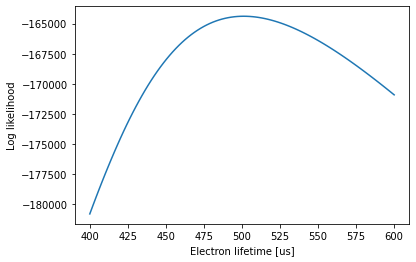

In [26]:
els = np.linspace(400, 600, 100)

results = np.zeros_like(els)
for i, el in enumerate(els):
    pars = guess.copy()
    pars['elife'] = el
    results[i] = kr_logl(dt, s2, pars)
    
plt.plot(els, results)
plt.xlabel("Electron lifetime [us]")
plt.ylabel("Log likelihood")

We just need to maximize this -- find the most likely value. It's only slightly more complex than the plot lets on, as the likelihood is a function of n0 and s0 also.

You can use any minimizer you want for this. I often use scipy.optimize.minimize, but iminuit also works well (and sometimes better).

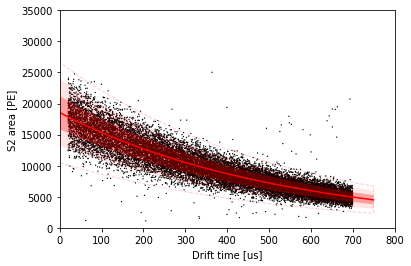

In [27]:
from scipy.optimize import minimize

def array_to_dict(x):
    return dict(zip(guess.keys(), x.tolist()))

optresult = minimize(
    # Note -2: need to flip sign to find max. likelihood point.
    # 2 is just convention (you will understand when you go deeper into statistics)
    lambda x: -2 * kr_logl(dt, s2, array_to_dict(x)), 
     x0=np.array(list(guess.values())))
result = array_to_dict(optresult.x)
comparison(df, result, scatter=True)

Be careful with using `scipy.optimize.curve_fit`: this assumes all data comes from a single line, with a Gaussian spread on the y-value (with fixed relative sigma). That's not necessarily a bad assumption, but be aware that's what it's doing. In any case, if you use it, think about what the `sigma` and `absolute_sigma` arguments should be.

## 6. Check the fit is good

Based on the plot above, the fit looks OK... but it is always hard to see by eye. This topic could fill an entire analysis by itself; I'll only do a few basic qualitative checks here. 

First, let's compute cS2 using this new electron lifetime. This should now be independent of drift time.

(<matplotlib.collections.QuadMesh at 0x7f7b3a65e048>,
 <matplotlib.colorbar.Colorbar at 0x7f7b3ac74780>)

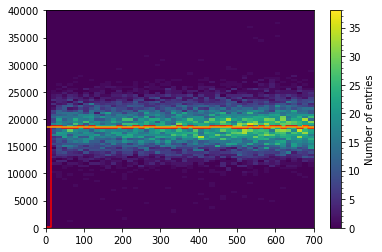

In [28]:
df['cs2_ourfit'] = df['s2_area'] * np.exp(dt/result['elife'])
mh = Histdd(dt, df['cs2_ourfit'], bins=(np.linspace(0, 700, 50), np.linspace(0, 40e3, 100)))
mh.percentile(50, axis=1).plot(color='r')
plt.axhline(np.median(df['cs2_ourfit']), color='orange')
mh.plot()

Looks good. But that only checks the mean: we also want to check if the distribution along each drift time slice is correctly modelled. For this we can compute the z-score of each event, and check that this has a standard normal distribution (or at least has mean at 0 and std of 1, independent of dt):

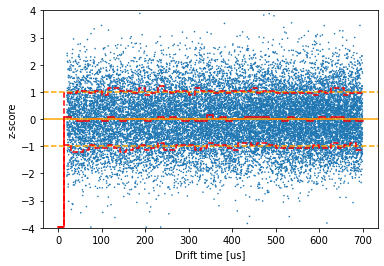

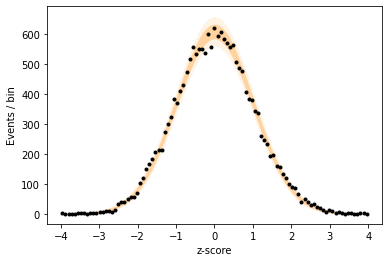

In [29]:
m, s = s2_mean_std(dt, result)
z = (s2 - m)/s
mh = Histdd(dt, z, bins=(np.linspace(0, 700, 50), np.linspace(-4, 4, 100)))

mh.percentile(50, axis=1).plot(color='r')
plt.axhline(0, color='orange')
for sign in [-1, 1]:
    plt.axhline(sign, color='orange', drawstyle='steps-mid', linestyle='--')
    mh.percentile(100 * stats.norm.cdf(sign), axis=1).plot(color='r', linestyle='--')
plt.scatter(dt, z, marker='.', edgecolors='none', s=10)
plt.ylim(-4, 4)
plt.xlabel("Drift time [us]")
plt.ylabel("z-score")
plt.show()

h = mh.sum(axis=0)
plt.plot(h.bin_centers, h.histogram, marker='.', c='k', linestyle='', linewidth=0)
mean = np.diff(stats.norm.cdf(h.bin_edges)) * h.n
for sigma, alpha in ([1, 0.3], [2, 0.1]):
    plt.fill_between(h.bin_centers, 
                     stats.poisson(mean).ppf(stats.norm.cdf(-sigma)),
                     stats.poisson(mean).ppf(stats.norm.cdf(sigma)),
                     alpha=alpha, color='darkorange', linewidth=0)
plt.xlabel("z-score")
plt.ylabel("Events / bin")
plt.show()

You could now go further and quantify the normality of this distribution with various statistics. For now though, it seems we're doing well.

### 7. Estimate errors

If you do a fit, the fitter will usually give you an error estimate. Or, it might return something called an "inverse Hessian", which is an estimate of the [covariance matrix](https://en.wikipedia.org/wiki/Covariance_matrix) of the result (it becomes exact if the log likelihood is parabolic, but when exactly that happens is another matter... very roughly when you have a lot of data). So you can read the errors off the diagonal:

In [20]:
errors = array_to_dict(np.diag(optresult.hess_inv)**0.5)
for k in result:
    print(f"{k}: {result[k]:.2f} +- {errors[k]:.2f}")

elife: 529.89 +- 1.07
n0: 618.17 +- 1.01
sigma_0: 89.63 +- 0.32


Notice the elife error is very small: about 0.2%, even though we only had around a thousand events! This shows the unmatched statistical power of a full unbinned likelihood fit.


... unfortunately, there are also **systematic uncertainties** due to analysis choices . One rough way to estimate these is to perturb some choices, such as cut boundaries or number of sigmas assigned to outliers, within reasonable values. These will likely give you variations larger than the statistical error, unless you have very few events. If they are very large, it shows your method isn't very good -- maybe you have a strong cut that is too correlated with the dimensions you fit in, for example.

You can also try a completely different method, then treat the difference as a systematic error. For example, the elife was also fit during XENON1T (processed with pax, and with different cuts). The result is stored in the runs db:

In [21]:
st.run_metadata(run_info['name'], 'processor.DEFAULT.electron_lifetime_liquid')

{'processor.DEFAULT.electron_lifetime_liquid': 482906.3918929287}

This is in nanoseconds, so and somewhat lower than we found. So is there are a big systematic uncertainty or is one of the methods just wrong?

... well, we did not apply the S2(x,y) correction in this notebook, which could have biased our result. Kr may be relatively homogeneous in (x,y), but due to the field distortion, event positions are biased inwards deep in the TPC. In the center of the detector, the S2 gain is higher due to the higher extraction field (due to anode sagging). Thus the S2 at high z is somewhat increased, leading to an exaggerated elife.

### 8. Over to you!

Suggestions for extension:
  * Create a strax plugin (or modify an existing one) to output the S2(x,y) correction. Then use the S2(x,y) corrected S2 area instead of raw S2 in the analysis.
  * Try the method here for all Kr runs we have processed. Do NOT just change the run id 30 times please! Instead, you could make a single cell that does the entire process for one run (calling/defining functions as necessary), then make a for loop around it. You could even make that single-cell into a straxen mini-analysis, if you like.
  * Try different cuts (e.g. S2 width) to get rid of more outliers.
  * Try to extract the elife from some other population, e.g. background radon alphas.
  * Try a different fitting method, e.g. use minuit, or use a binned likelihood, or ...